Created trimed video to get only reliable frames and to make process faster 

In [53]:
import cv2

def hhmmss_to_seconds(hhmmss):
    hh, mm, ss = map(int, hhmmss.split(':'))
    return hh * 3600 + mm * 60 + ss

def trim_video(input_path, output_path, start_time, end_time):
    start_seconds = hhmmss_to_seconds(start_time)
    end_seconds = hhmmss_to_seconds(end_time)

    cap = cv2.VideoCapture(input_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    start_frame = start_seconds * fps
    end_frame = end_seconds * fps

    if end_frame > total_frames:
        end_frame = total_frames

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    current_frame = start_frame
    while cap.isOpened() and current_frame < end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
        current_frame += 1

    cap.release()
    out.release()

# Example usage
input_video_path = '/mnt/hgfs/Desktop/WSC.mp4'
output_video_path = '/mnt/hgfs/Desktop/WSC_trimed.mp4'
start_time = '01:20:00'  # hh:mm:ss
end_time = '02:14:00'    # hh:mm:ss

# trim_video(input_video_path, output_video_path, start_time, end_time)



Compared each frame by computing similarity which is Intersection over Union  which says i.e. Area of Intersection / Area of Union frames ==> 367877

Frame 0: Similarity 0.96
Frame 1: Similarity 0.96
Frame 2: Similarity 0.96
Frame 3: Similarity 0.96
Frame 4: Similarity 0.96
Frame 5: Similarity 0.96
Frame 6: Similarity 0.96
Frame 7: Similarity 0.96
Frame 8: Similarity 0.96
Frame 9: Similarity 0.96
Frame 10: Similarity 0.96
Frame 11: Similarity 0.96
Frame 12: Similarity 0.96
Frame 13: Similarity 0.96
Frame 14: Similarity 0.96
Frame 15: Similarity 0.96
Frame 16: Similarity 0.95
Frame 17: Similarity 0.95
Frame 18: Similarity 0.95
Frame 19: Similarity 0.95
Frame 20: Similarity 0.95
Frame 21: Similarity 0.94
Frame 22: Similarity 0.94
Frame 23: Similarity 0.94
Frame 24: Similarity 0.94
Frame 25: Similarity 0.93
Frame 26: Similarity 0.93
Frame 27: Similarity 0.93
Frame 28: Similarity 0.93
Frame 29: Similarity 0.93
Frame 30: Similarity 0.92
Frame 31: Similarity 0.92
Frame 32: Similarity 0.91
Frame 33: Similarity 0.91
Frame 34: Similarity 0.90
Frame 35: Similarity 0.90
Frame 36: Similarity 0.89
Frame 37: Similarity 0.89
Frame 38: Similarity 0

[mpeg4 @ 0xaaaaeab23d30] header damaged


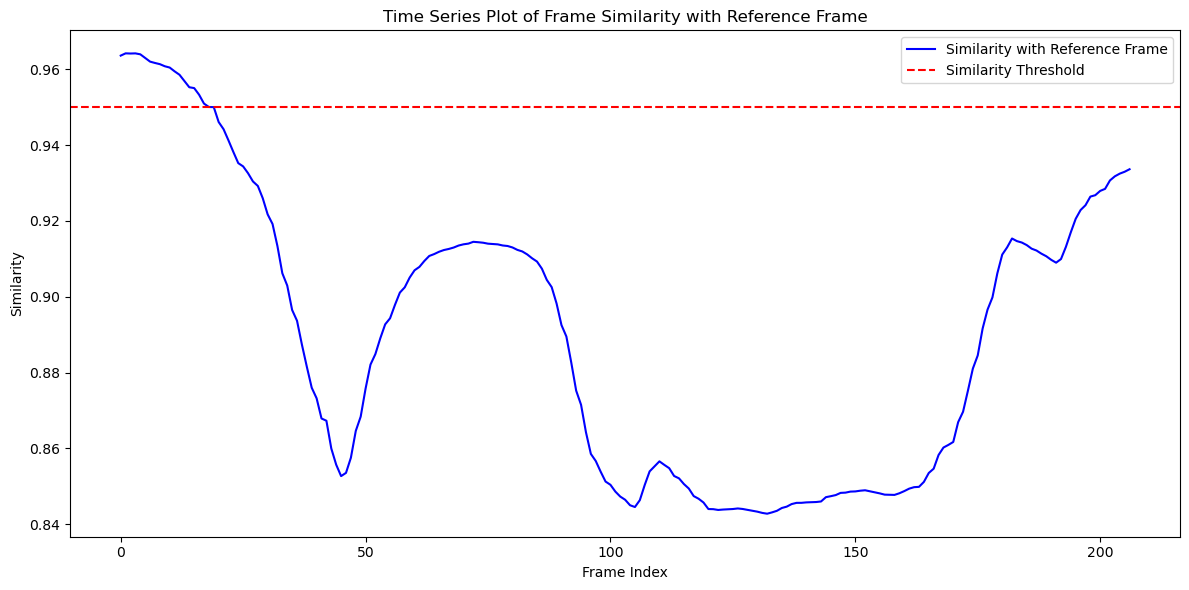

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_similarity(frame1, frame2):
    
    hsv1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)
    
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    
    mask1 = cv2.inRange(hsv1, lower_green, upper_green)
    mask2 = cv2.inRange(hsv2, lower_green, upper_green)
    
    intersection = cv2.bitwise_and(mask1, mask2)
    
    similarity = np.sum(intersection) / (np.sum(mask1) + np.sum(mask2) - np.sum(intersection))
    
    return similarity

def plot_similarity_graph(video_path, ref_frame_path, threshold=0.95):
    cap = cv2.VideoCapture(video_path)
    ref_frame = cv2.imread(ref_frame_path)

    if ref_frame is None:
        print("Error: Could not load reference frame.")
        return

    frame_count = 0
    frame_indices = []
    similarities = []

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        similarity = compute_similarity(ref_frame, frame)
        similarities.append(similarity)
        frame_indices.append(frame_count)
        
        print(f"Frame {frame_count}: Similarity {similarity:.2f}")
        
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

    plt.figure(figsize=(12, 6))
    plt.plot(frame_indices, similarities, label='Similarity with Reference Frame', color='blue')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Similarity Threshold')
    plt.title('Time Series Plot of Frame Similarity with Reference Frame')
    plt.xlabel('Frame Index')
    plt.ylabel('Similarity')
    plt.legend()
    plt.tight_layout()
    plt.show()


video_path = '/mnt/hgfs/Desktop/WSC_trimed.mp4'
ref_frame_path = '/mnt/hgfs/Desktop/WSC sample.png'
plot_similarity_graph(video_path, ref_frame_path)


In [55]:
import cv2
import numpy as np
import os

output_path = 'frames'
if not os.path.exists(output_path):
    os.makedirs(output_path)

def compute_similarity(frame1, frame2):
    
    hsv1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2HSV)
    hsv2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2HSV)
    
    # Range for the color green in HSV space
    lower_green = np.array([35, 100, 100])
    upper_green = np.array([85, 255, 255])
    
    # masks for the green color in both frames
    mask1 = cv2.inRange(hsv1, lower_green, upper_green)
    mask2 = cv2.inRange(hsv2, lower_green, upper_green)
    
    # intersection of the two masks
    intersection = cv2.bitwise_and(mask1, mask2)
    
    #  similarity as the ratio of intersection to the union of the masks
    similarity = np.sum(intersection) / (np.sum(mask1) + np.sum(mask2) - np.sum(intersection))
    
    return similarity

def side_view_frames(video_path, ref_frame_path, threshold=0.95, output_path='frames'):
    cap = cv2.VideoCapture(video_path)
    ref_frame = cv2.imread(ref_frame_path)

    if ref_frame is None:
        print("Error: Could not load reference frame.")
        return

    frame_count = 0

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        similarity = compute_similarity(ref_frame, frame)
        if similarity >= threshold:
            frame_path = f"{output_path}/frame_{frame_count:04d}_{similarity:.2f}.jpg"
            cv2.imwrite(frame_path, frame)
            cv2.rectangle(frame, (10, 10), (110, 50), (0, 255, 0), -1)
            cv2.putText(frame, "Saved", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
        else:
            cv2.rectangle(frame, (10, 10), (210, 50), (0, 0, 255), -1)
            cv2.putText(frame, "Not Saved", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        frame_count += 1
        cv2.imshow('Frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    print(f"Total frames: {frame_count}")

# Usage
video_path = '/mnt/hgfs/Desktop/WSC_trimed.mp4'
ref_frame_path = '/mnt/hgfs/Desktop/WSC sample.png'
# side_view_frames(video_path, ref_frame_path)


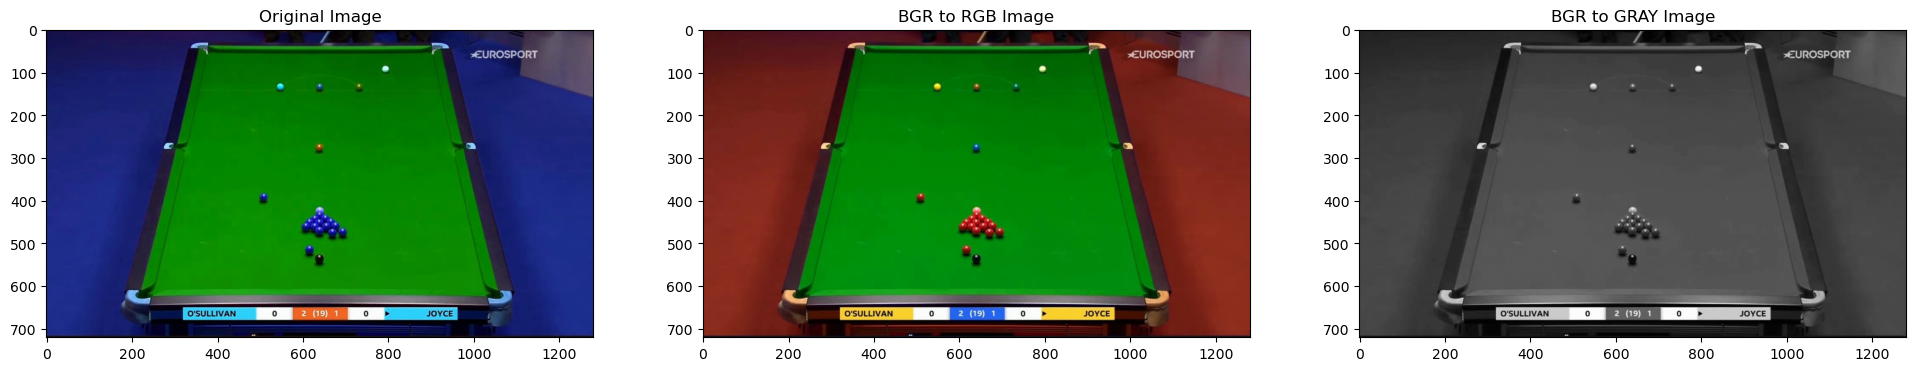

In [56]:
from matplotlib import pyplot as plt

image_path = "/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg"
image = cv2.imread(image_path)

# Convert to grayscale
RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(24,24))
plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.subplot(1,3,2)
plt.title("BGR to RGB Image")
plt.imshow(RGB_image)
plt.subplot(1,3,3)
plt.title("BGR to GRAY Image")
plt.imshow(gray_image,cmap='gray')
plt.show()

Understanding of sobel function 

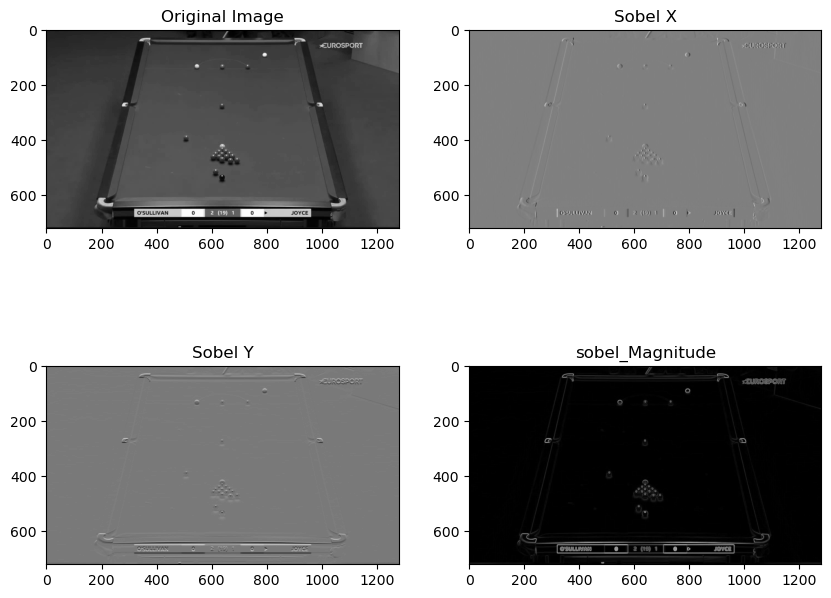

In [57]:
def PAC(img):

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

    sobel_mag = np.sqrt(sobelx**2 + sobely**2) 
    sobel_mag = cv2.normalize(sobel_mag, None, 0, 255, cv2.NORM_MINMAX)

    return sobel_mag,sobelx,sobely,img

sobel_mag,sobelx,sobely,img = PAC(gray_image)
sobel_mag,sobelx,sobely,img

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.subplot(2, 2, 2)
plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X')
plt.subplot(2, 2, 3)
plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y')
plt.subplot(2, 2, 4)
plt.imshow(sobel_mag, cmap='gray')
plt.title('sobel_Magnitude')
plt.show()

In [58]:
height, width = sobel_mag.shape
print(f"height:{height},width:{width}")

height:720,width:1280


Using the hough transform we have defined the corners using sobel gradiants 


Detected lines (rho, theta):
rho: -886, theta in degrees: 167.0
rho: 37, theta in degrees: 90.0
rho: 40, theta in degrees: 90.0
rho: 356, theta in degrees: 13.0
rho: 361, theta in degrees: 14.0
rho: 606, theta in degrees: 90.0
rho: 620, theta in degrees: 90.0
rho: 637, theta in degrees: 90.0
rho: 643, theta in degrees: 90.0
rho: 648, theta in degrees: 90.0
rho: 651, theta in degrees: 90.0
rho: 652, theta in degrees: 90.0
rho: 677, theta in degrees: 90.0
rho: 681, theta in degrees: 90.0
rho: 690, theta in degrees: 90.0
rho: 715, theta in degrees: 90.0
Detected corners (intersections):
x: 356, y: 36
x: 356, y: 39
x: 362, y: 36
x: 362, y: 39


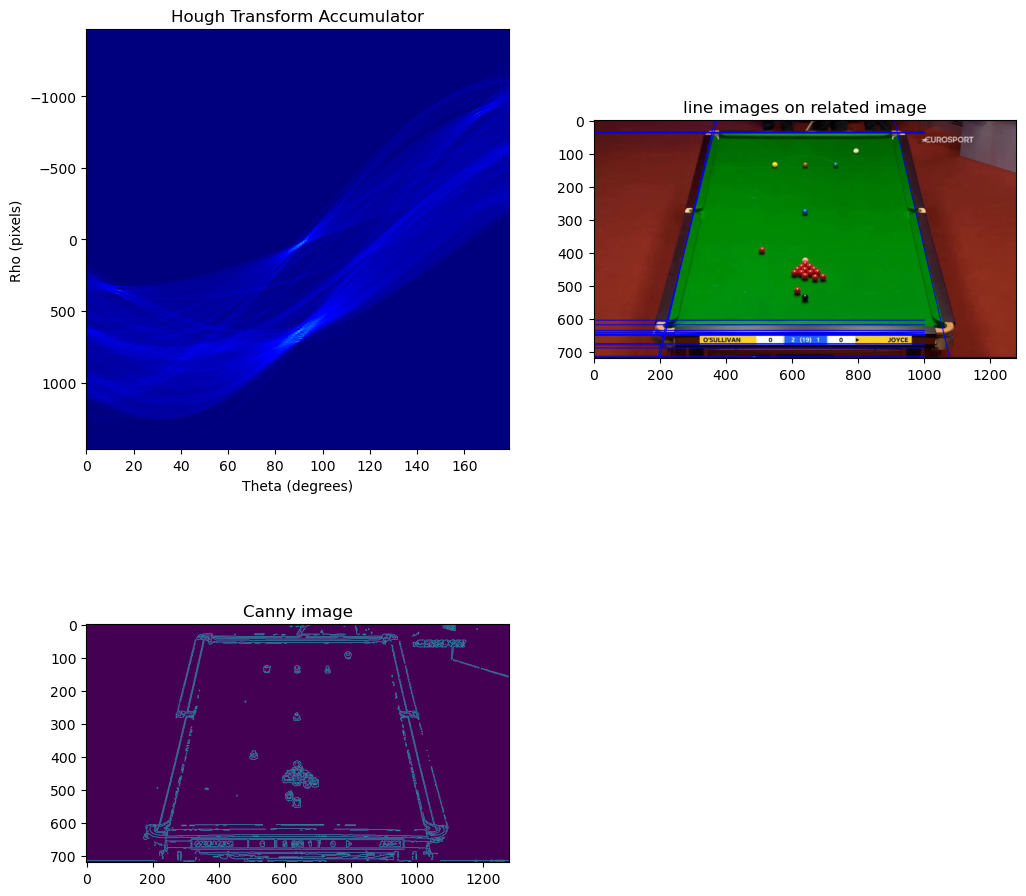

In [59]:
def hough_transform(edges, rho_res=1, theta_res=np.pi/180, threshold=280):
    height, width = edges.shape
    max_dist = int(np.sqrt(height**2 + width**2))
    rhos = np.arange(-max_dist, max_dist, rho_res)
    thetas = np.arange(0, np.pi, theta_res)
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    edge_points = np.argwhere(edges)
    
    for y, x in edge_points:
        for theta_idx in range(len(thetas)):
            theta = thetas[theta_idx]
            rho = int(x * np.cos(theta) + y * np.sin(theta) + max_dist)
            accumulator[rho, theta_idx] += 1

    
    lines = []
    for rho_idx in range(accumulator.shape[0]):
        for theta_idx in range(accumulator.shape[1]):
            if accumulator[rho_idx, theta_idx] >= threshold:
                rho = rhos[rho_idx]
                theta = thetas[theta_idx]
                lines.append((rho, theta))

    return lines,accumulator,rhos,thetas

def draw_lines(image, lines):
    line_img = np.copy(image)
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return line_img

def compute_intersections(lines):
    intersections = []
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            rho1, theta1 = lines[i]
            rho2, theta2 = lines[j]
            a1, b1 = np.cos(theta1), np.sin(theta1)
            a2, b2 = np.cos(theta2), np.sin(theta2)
            determinant = a1 * b2 - a2 * b1
            if determinant != 0:
                x = (b2 * rho1 - b1 * rho2) / determinant
                y = (a1 * rho2 - a2 * rho1) / determinant
                intersections.append((int(x), int(y)))
    return intersections

def filter_and_sort_intersections(intersections, image_shape):
    height, width = image_shape[:2]
    valid_intersections = []

    for point in intersections:
        x, y = point
        if 0 <= x < width and 0 <= y < height: # Check if the point is within the image boundaries
            valid_intersections.append(point)

    def distance_from_origin(point):
        x, y = point
        return x**2 + y**2

    valid_intersections.sort(key=distance_from_origin)  # Sort the valid intersections by their distance from the top-left corner(0,0)
    return valid_intersections

image = cv2.imread('/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel_mag = np.sqrt(sobelx**2 + sobely**2)
sobel_mag = cv2.convertScaleAbs(sobel_mag)

_, threshold = cv2.threshold(sobel_mag, 50, 255, cv2.THRESH_BINARY)
threshold = np.uint8(threshold)
edges = cv2.Canny(threshold, 50, 150, apertureSize=3)

lines,accumulator,rhos,thetas = hough_transform(edges)
intersections = compute_intersections(lines)
valid_intersections = filter_and_sort_intersections(intersections, image.shape)

line_img = draw_lines(image, lines) # Draw lines and intersections on the image

for (x, y) in valid_intersections:
    cv2.circle(line_img, (x, y), 5, (0, 255, 0), -1)

# Select the four corners
if len(valid_intersections) >= 4:
    corners = valid_intersections[:4]
else:
    corners = valid_intersections

line_img = draw_lines(image, lines)

print("Detected lines (rho, theta):")
for line in lines:
    print(f"rho: {line[0]}, theta in degrees: {np.rad2deg(line[1])}")

print("Detected corners (intersections):")
for (x, y) in corners:
    print(f"x: {x}, y: {y}")

plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.imshow(accumulator, cmap='jet',aspect='auto', extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[-1], rhos[0]])
plt.title('Hough Transform Accumulator')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
plt.title("line images on related image")
plt.subplot(2,2,3)
plt.imshow(edges)
plt.title('Canny image')
plt.show()


In [63]:
color_ranges = {
    'yellow': ([20, 100, 100], [30, 255, 255]),
    'green': ([35, 100, 100], [85, 255, 255]),
    'brown': ([10, 100, 20], [20, 255, 200]),
    'blue': ([100, 150, 0], [140, 255, 255]),
    'pink': ([160, 70, 70], [180, 255, 255]),
    'black': ([0, 0, 0], [180, 255, 50])
}

def find_spot_coordinates(image, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array(lower_hsv, dtype="uint8")
    upper = np.array(upper_hsv, dtype="uint8")
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(image, image, mask=mask)

    # Find contours
    gray_output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    contours, _ = cv2.findContours(gray_output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea) # Get the largest contour which we assume is the spot
        M = cv2.moments(largest_contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            return (cX, cY)
    return None

# Load and process the image
image_path = '/mnt/hgfs/Desktop/frames/frame_20625_0.99.jpg' 
image = cv2.imread(image_path)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create a copy of the image to draw spots
output_image = np.copy(rgb_image)

# Find and draw each spot
detected_coordinates = {}
for color, (lower, upper) in color_ranges.items():
    coordinates = find_spot_coordinates(rgb_image, lower, upper)
    if coordinates:
        detected_coordinates[color] = coordinates


baulk_line_y = np.mean([detected_coordinates['yellow'][1], detected_coordinates['green'][1], detected_coordinates['brown'][1]])
ball_radius_y_offsets = {color: detected_coordinates[color][1] - baulk_line_y for color in ['yellow', 'green', 'brown']}
avg_radius_y_offset = np.mean(list(ball_radius_y_offsets.values()))

spots_coordinates = {color: (detected_coordinates[color][0], detected_coordinates[color][1] - avg_radius_y_offset) for color in detected_coordinates}

for color, coordinates in spots_coordinates.items():
    spots_coordinates[color] = (int(coordinates[0]), int(coordinates[1]))


print(f"spots coordinates of YGBBPB are {spots_coordinates}")

spots coordinates of YGBBPB are {'yellow': (405, 664), 'green': (638, 359), 'brown': (1056, 664), 'blue': (659, 663), 'pink': (228, 31), 'black': (637, 700)}


Evaluation of DLT algorithm using World points and image_points (i.e. 6-spots and 4-corners coordinates) . Where World points are calculated manually as in 3D coordinates as we have Found in the code above 

In [71]:
def DLT_1(world_points, image_points):
    num_points = world_points.shape[0]
    A = []

    for i in range(num_points):
        X, Y, Z = world_points[i]
        u, v = image_points[i]

        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u])
        A.append([ 0,  0,  0,  0,-X, -Y, -Z, -1, v * X, v * Y, v * Z, v])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    P = V[-1].reshape(3, 4)

    return P

def decompose_camera_matrix(P):
    M = P[:, :3]
    p4 = P[:, 3]

    K, R = np.linalg.qr(np.linalg.inv(M))
    K = np.linalg.inv(K)

    T = np.linalg.inv(K).dot(p4)
    C = -R.T.dot(T)

    return K, R, C

def main_DLT_1():

    world_coords = {'yellow': [0.292, 3.277, 0],'green': [0.292, 0.292, 0],'brown': [0.292, 1.778, 0],'blue': [1.778, 1.778, 0],'pink': [2.565, 1.778, 0],'black': [3.261, 1.778, 0],'corner_top_left': [0, 0, 0],'corner_top_right': [3.569, 0, 0],'corner_bottom_left': [0, 3.569, 0],'corner_bottom_right': [3.569, 3.569, 0]}
    spots_coordinates = {'yellow': [405, 664],'green': [638, 359],'brown': [1056, 664],'blue': [659, 663],'pink': [228, 31],'black': [637, 700],'corner_top_left': [356, 36],'corner_top_right': [356, 39],'corner_bottom_left': [362, 36],'corner_bottom_right': [362, 39]}

    detected_colors = list(spots_coordinates.keys())
    world_coords = {color: world_coords[color] for color in detected_colors}

    image_points = np.array([spots_coordinates[color] for color in detected_colors])
    world_points = np.array([world_coords[color] for color in detected_colors])

    # Compute the camera matrix P 
    P = DLT_1(world_points, image_points)
    print(f"Detected colours nad corners are {detected_colors}")
    print("Estimated camera matrix P:")
    print(P)

    # Decompose P to get K, R, and C
    K, R, C = decompose_camera_matrix(P)
    print("Intrinsic matrix K:")
    print(K)
    print("Rotation matrix R:")
    print(R)
    print("Camera center C:")
    print(C)

# Usage
main_DLT_1()


Detected colours nad corners are ['yellow', 'green', 'brown', 'blue', 'pink', 'black', 'corner_top_left', 'corner_top_right', 'corner_bottom_left', 'corner_bottom_right']
Estimated camera matrix P:
[[ 0.00000000e+00  4.22991165e-31 -1.93792587e-17 -1.16742201e-30]
 [ 1.42940273e-31  7.32570853e-32 -2.21197312e-16 -6.29755845e-31]
 [ 1.93875249e-34  6.00343810e-34  1.00000000e+00 -2.53042827e-33]]
Intrinsic matrix K:
[[-4.56091754e-01  8.89932757e-01 -4.45840720e-34]
 [-8.89932757e-01 -4.56091754e-01  4.46347796e-34]
 [ 1.93875249e-34  6.00343810e-34  1.00000000e+00]]
Rotation matrix R:
[[ 2.65651034e+30 -3.19078552e+30 -6.54311980e+14]
 [ 0.00000000e+00 -6.22590637e+30 -1.37715375e+15]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Camera center C:
[-2.90327865e+00 -1.19283411e+00 -3.20115087e-16]


Evaluation of DLT algorithm using World points and image_points (i.e. 6-spots and 4-corners coordinates) . Where World points are calculated manually as in 3D coordinates whic were already given

In [72]:
def DLT_2(world_points, image_points):
    num_points = world_points.shape[0]
    A = []

    for i in range(num_points):
        X, Y, Z = world_points[i]
        u, v = image_points[i]

        A.append([-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u])
        A.append([ 0,  0,  0,  0,-X, -Y, -Z, -1, v * X, v * Y, v * Z, v])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    P = V[-1].reshape(3, 4)

    return P

def decompose_camera_matrix(P):
    M = P[:, :3]
    p4 = P[:, 3]

    K, R = np.linalg.qr(np.linalg.inv(M))
    K = np.linalg.inv(K)

    T = np.linalg.inv(K).dot(p4)
    C = -R.T.dot(T)

    return K, R, C

def main_DLT_2():
    # Predefined correspondences for DLT
    world_points = np.array([
        [-0.889, -1.7845, 0.03], [0.889, -1.7845, 0.03], 
        [0.889, 1.7845, 0.03], [-0.889, 1.7845, 0.03], 
        [-0.292, 1.0475, 0], [0.292, 1.0475, 0], 
        [0, 1.0475, 0], [0, 0, 0], 
        [0, -0.89225, 0], [0, -1.4605, 0]
    ])

    image_points = np.array([
        [253, 608], [1027, 608], 
        [904, 47], [376, 47], 
        [548, 143], [732, 143], 
        [640, 143], [640, 287], 
        [640, 437], [640, 549]
    ])

    # Compute the camera matrix P using DLT
    P = DLT_2(world_points, image_points)
    print("Estimated camera matrix P:")
    print(P)

    # Decompose P to get K, R, and C
    K, R, C = decompose_camera_matrix(P)
    print("Intrinsic matrix K:")
    print(K)
    print("Rotation matrix R:")
    print(R)
    print("Camera center C:")
    print(C)

if __name__ == "__main__":
    main_DLT_2()


Estimated camera matrix P:
[[ 3.80693501e-01  7.30675269e-02 -1.17515453e-01  6.93739161e-01]
 [-9.74254019e-07 -1.32181530e-01 -4.90514307e-01  3.10760723e-01]
 [-3.06314256e-09  1.14167966e-04 -1.83486607e-04  1.08396634e-03]]
Intrinsic matrix K:
[[-1.00000000e+00 -1.64944231e-05  6.43102973e-06]
 [ 1.06072560e-05 -8.49059671e-01 -5.28296958e-01]
 [ 1.41742815e-05 -5.28296957e-01  8.49059671e-01]]
Rotation matrix R:
[[-2.62677153e+00  3.42373320e-04  1.68138635e+03]
 [ 0.00000000e+00  2.69275246e+00 -4.31931607e+03]
 [ 0.00000000e+00  0.00000000e+00 -4.62736593e+03]]
Camera center C:
[-1.82228558e+00  7.12304927e-01 -7.31168923e+02]


In [76]:
import time

start_time = time.time()
main_DLT_1()
time1 = time.time() - start_time

start_time = time.time()
main_DLT_2()
time2 = time.time() - start_time



if time1 > time2:
    print(f"As DLT_2 ran in less amount of compuation time {time2} it wins")
else:
    print(f"As DLT_1 ran in less amount of compuation time {time1} it wins")



Detected colours nad corners are ['yellow', 'green', 'brown', 'blue', 'pink', 'black', 'corner_top_left', 'corner_top_right', 'corner_bottom_left', 'corner_bottom_right']
Estimated camera matrix P:
[[ 0.00000000e+00  4.22991165e-31 -1.93792587e-17 -1.16742201e-30]
 [ 1.42940273e-31  7.32570853e-32 -2.21197312e-16 -6.29755845e-31]
 [ 1.93875249e-34  6.00343810e-34  1.00000000e+00 -2.53042827e-33]]
Intrinsic matrix K:
[[-4.56091754e-01  8.89932757e-01 -4.45840720e-34]
 [-8.89932757e-01 -4.56091754e-01  4.46347796e-34]
 [ 1.93875249e-34  6.00343810e-34  1.00000000e+00]]
Rotation matrix R:
[[ 2.65651034e+30 -3.19078552e+30 -6.54311980e+14]
 [ 0.00000000e+00 -6.22590637e+30 -1.37715375e+15]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Camera center C:
[-2.90327865e+00 -1.19283411e+00 -3.20115087e-16]
Estimated camera matrix P:
[[ 3.80693501e-01  7.30675269e-02 -1.17515453e-01  6.93739161e-01]
 [-9.74254019e-07 -1.32181530e-01 -4.90514307e-01  3.10760723e-01]
 [-3.06314256e-09  1.1416